<a href="https://colab.research.google.com/github/DanielDLX/DLfinal/blob/master/bert_AGnews_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 导入包
# transformer提供了一些训练好的模型，可以很方便的使用。
!pip install transformers
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.manifold import TSNE
import tqdm
# 使用分类的模型，增加了一个head用于分类。
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
% matplotlib inline

tf.__version__

'2.2.0'

In [2]:
# 导入现成的分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
# 数据链接，可以在 https://course.fast.ai/datasets 找到。
# agnews数据集，类别，标题，描述。
ag_url = 'https://s3.amazonaws.com/fast-ai-nlp/ag_news_csv.tgz'

In [4]:
# 下载数据，并指定此时数据集的目录
ag_zip_file = tf.keras.utils.get_file(origin=ag_url,fname='ag_news_csv.tgz', extract=True)
base_dir = os.path.join(os.path.dirname(ag_zip_file), 'ag_news_csv')
os.listdir(base_dir)

['test.csv', 'classes.txt', 'train.csv', 'readme.txt']

In [5]:
# 读取数据
# 为了方便测试代码的时候少用几个数据,1000个数据可以让准确率上升到0.68
# num = 10000
train = pd.read_csv(os.path.join(base_dir, 'train.csv'), header=None)
# train = train.sample(n=num)
print(len(train))
print(train.head())
test = pd.read_csv(os.path.join(base_dir, 'test.csv'), header=None)
# test = test.sample(n=1000)
print(len(test))
print(test.head())
f = open(os.path.join(base_dir, 'classes.txt'))
classes = f.readlines()
classes = [s.strip() for s in classes]
print(classes)

120000
   0  ...                                                  2
0  3  ...  Reuters - Short-sellers, Wall Street's dwindli...
1  3  ...  Reuters - Private investment firm Carlyle Grou...
2  3  ...  Reuters - Soaring crude prices plus worries\ab...
3  3  ...  Reuters - Authorities have halted oil export\f...
4  3  ...  AFP - Tearaway world oil prices, toppling reco...

[5 rows x 3 columns]
7600
   0  ...                                                  2
0  3  ...  Unions representing workers at Turner   Newall...
1  4  ...  SPACE.com - TORONTO, Canada -- A second\team o...
2  4  ...  AP - A company founded by a chemistry research...
3  4  ...  AP - It's barely dawn when Mike Fitzpatrick st...
4  4  ...  AP - Southern California's smog-fighting agenc...

[5 rows x 3 columns]
['World', 'Sports', 'Business', 'Sci/Tech']


In [6]:
# 预处理数据
# 按照上面的例子把数据集中的文本进行分词处理，并且得到对应的labels。
max_length = 128
max_length_temp = max_length - 2
train_ids = []
test_ids = []
for i in tqdm.notebook.trange(train.shape[0]):
  if len(train[2][train[2].index[i]]) > max_length_temp:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
for i in tqdm.notebook.trange(test.shape[0]):
  if len(test[2][test[2].index[i]]) > max_length_temp:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
train_labels = train[0].values - 1
test_labels = test[0].values - 1

In [7]:
# 把数据转成tensorflow张量
# train_ids是tf.Tensor组成得列表，所以用concat组合一下就行
train_ids = tf.concat(train_ids, 0)
# 把train_mask初始化为1，然后把train_ids等于0（PAD的部分）对应的值赋为0
train_mask = tf.ones(train_ids.shape)
train_mask = tf.where(tf.math.greater(train_ids, 0), train_mask, 0)
# labels本身是numpy数组，转为tf.Tensor
train_labels = tf.convert_to_tensor(train_labels)

# 测试集的处理同理test
test_ids = tf.concat(test_ids, 0)
test_mask = tf.ones(test_ids.shape)
test_mask = tf.where(tf.math.greater(test_ids, 0), test_mask, 0)
test_labels = tf.convert_to_tensor(test_labels)

In [8]:
print(train_ids[0])
print(train_mask[0])
print(train_labels[0])

tf.Tensor(
[  101 26665  1011  2460  1011 19041  1010  2813  2395  1005  1055  1040
 11101  2989  1032  2316  1997 11087  1011 22330  8713  2015  1010  2024
  3773  2665  2153  1012   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int32)
tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.

In [9]:
# 训练参数
hidden_size=128
epochs = 5
batch_size = 256
validation_rate = 0.1

In [10]:
# 模型放在这里
# model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4) # 分类类别数
cnfg = BertConfig(hidden_size=hidden_size, num_labels=4, num_hidden_layers=6, num_attention_heads=4, intermediate_size=512)
model = TFBertForSequenceClassification(cnfg)
# model.summary()
# model.config

In [11]:
# 简单分类算法
model_compare = tf.keras.Sequential([
    tf.keras.layers.Embedding(30522, hidden_size),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4)
])
model_compare.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         3906816   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 4,009,892
Trainable params: 4,009,892
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 模型编译
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [13]:
optimizer_c = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
loss_c = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_c = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model_compare.compile(optimizer=optimizer_c, loss=loss_c, metrics=[metric_c])

In [14]:
# history是按照一个epoch记录一次，间隔太大了，所以手动重写一个基于batch的
class BatchCallback(tf.keras.callbacks.History):
  def __init__(self):
    self.batch = []
    self.history = {'loss':[], 'accuracy':[]}
  def on_train_batch_end(self, batch, logs=None):
    self.batch.append(batch)
    for k, v in logs.items():
      self.history[k].append(v)

In [15]:
# 模型训练
history = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

Epoch 1/5
469/469 [==============================] - 281s 600ms/step - loss: 0.7979 - accuracy: 0.6334
Epoch 2/5
469/469 [==============================] - 282s 601ms/step - loss: 0.3133 - accuracy: 0.8965
Epoch 3/5
469/469 [==============================] - 282s 601ms/step - loss: 0.2448 - accuracy: 0.9189
Epoch 4/5
469/469 [==============================] - 282s 601ms/step - loss: 0.2067 - accuracy: 0.9317
Epoch 5/5
469/469 [==============================] - 282s 601ms/step - loss: 0.1779 - accuracy: 0.9412


In [16]:
history_compare = model_compare.fit(
    x=[train_ids, train_mask],
    y=train_labels,
    batch_size=batch_size, 
    epochs=epochs,
    verbose=1,
    callbacks=[BatchCallback()],
    shuffle=True
)

Epoch 1/5
469/469 [==============================] - 56s 118ms/step - loss: 1.0010 - accuracy: 0.6257
Epoch 2/5
469/469 [==============================] - 55s 118ms/step - loss: 0.4456 - accuracy: 0.8505
Epoch 3/5
469/469 [==============================] - 55s 118ms/step - loss: 0.3347 - accuracy: 0.8884
Epoch 4/5
469/469 [==============================] - 55s 117ms/step - loss: 0.2842 - accuracy: 0.9063
Epoch 5/5
469/469 [==============================] - 55s 118ms/step - loss: 0.2436 - accuracy: 0.9194


In [17]:
# 模型测试
model.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=batch_size, 
        verbose=1)

30/30 [==============================] - 5s 181ms/step - loss: 0.3437 - accuracy: 0.8908


[0.3437187671661377, 0.8907894492149353]

In [18]:
model_compare.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=batch_size, 
        verbose=1)

30/30 [==============================] - 1s 21ms/step - loss: 0.3418 - accuracy: 0.8774


[0.34176021814346313, 0.8773684501647949]

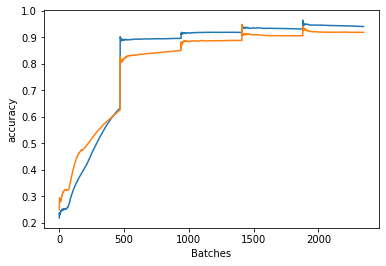

In [19]:
# 画图
def plot_graphs(history,history_compare, metric):
  plt.plot(history.history[metric])
  plt.plot(history_compare.history[metric])
  plt.xlabel("Batches")
  plt.ylabel(metric)
  plt.show()
plot_graphs(history, history_compare, 'accuracy')

In [20]:
index = None
for idx, layer in enumerate(model_compare.layers):
  print(idx, layer.name)

0 embedding
1 bidirectional
2 dense
3 dense_1


In [21]:
# 得到RNN模型embedding的方法，get embedding层后，输入词的id，得到embeding
# 用index更好
embedding_compare = model_compare.get_layer(index=0)

In [22]:
# 得到每个类的embedding
avg_pool1 = tf.keras.layers.AveragePooling2D(pool_size=(max_length, 1))
N = tf.shape(train_ids)[0] // 1000
embs_list = []
for i in range(N):
  embs = embedding_compare(train_ids[i*1000:(i+1)*1000])
  embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,max_length,hidden_size,1])), [-1,hidden_size])
  embs_list.append(embs)
embs = embedding_compare(train_ids[N*1000:])
embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,max_length,hidden_size,1])), [-1,hidden_size])
embs_list.append(embs)
seq_embs_compare = tf.concat(embs_list, 0)
class_embedding_compare = np.zeros([4,hidden_size])
for i in range(4):
  index = train_labels == i
  class_embs = seq_embs_compare[index]
  avg_pool2 = tf.keras.layers.AveragePooling2D(pool_size=(tf.shape(class_embs)[0], 1))
  class_embs = tf.reshape(class_embs,[1,-1,hidden_size,1])
  class_embs = avg_pool2(class_embs)
  class_embedding_compare[i] = tf.reshape(class_embs, [hidden_size]).numpy()
print(class_embedding_compare)

[[-0.0189259   0.01947984  0.02735049  0.02446172  0.03013637 -0.00707116
   0.02252922  0.03780469 -0.00696971  0.01253412  0.01921141 -0.00151155
  -0.01807895  0.01934391  0.03352149 -0.00187663 -0.02548178 -0.0071963
  -0.03624291 -0.01946854  0.02442412 -0.01627914  0.03377214  0.02275837
   0.01388257 -0.02666791 -0.02100003 -0.0055032  -0.00617231  0.01853186
  -0.01914453 -0.01044039  0.04476751 -0.02191747  0.0031671   0.02265313
   0.0028532   0.02442425  0.01555287 -0.02702955  0.02444965 -0.01537748
  -0.02386344 -0.0303854  -0.0025921   0.00968233  0.00616635  0.00640722
  -0.00249275 -0.02423683  0.03003389 -0.0176925  -0.00139981 -0.00142574
   0.01260075 -0.03056945 -0.00276684  0.00468568  0.03315408 -0.00195783
   0.00317879  0.02735642 -0.00999686  0.03864767  0.035928   -0.03411105
  -0.03995175 -0.00663056 -0.00886648  0.01192694 -0.03851772  0.02123173
  -0.01622485 -0.0324326  -0.00873587 -0.03650656 -0.00321416  0.00585888
   0.03603336  0.01464853  0.01075926 -

In [23]:
# 获得bert Embedding的方式，这里得到是整个embedding张量
embeddings = model.get_layer('bert').embeddings.word_embeddings

# 定义函数：通过词id 得到embedding
def get_embedding(input_ids, embeddings=embeddings):
  embeds = tf.gather(embeddings, input_ids)
  return embeds

In [24]:
# 得到每个类的embedding
N = tf.shape(train_ids)[0] // 1000
embs_list = []
for i in range(N):
  embs = get_embedding(train_ids[i*1000:(i+1)*1000])
  embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,max_length,hidden_size,1])), [-1,hidden_size])
  embs_list.append(embs)
embs = get_embedding(train_ids[N*1000:])
embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,max_length,hidden_size,1])), [-1,hidden_size])
embs_list.append(embs)
seq_embs = tf.concat(embs_list, 0)
print(seq_embs)
class_embedding = np.zeros([4,hidden_size])
for i in range(4):
  index = train_labels == i
  class_embs = seq_embs[index]
  avg_pool2 = tf.keras.layers.AveragePooling2D(pool_size=(tf.shape(class_embs)[0], 1))
  class_embs = tf.reshape(class_embs,[1,-1,hidden_size,1])
  class_embs = avg_pool2(class_embs)
  class_embedding[i] = tf.reshape(class_embs, [hidden_size]).numpy()
print(class_embedding)

tf.Tensor(
[[-0.02751189 -0.00504376  0.02836348 ... -0.01508925  0.01811048
  -0.00696054]
 [-0.0291103  -0.0068353   0.0290508  ... -0.01454638  0.01716696
  -0.00735704]
 [-0.02895394 -0.00528236  0.02997945 ... -0.01438874  0.01697626
  -0.00859054]
 ...
 [-0.02738489 -0.00664984  0.02643914 ... -0.01302929  0.01626625
  -0.00517814]
 [-0.02517835 -0.00585978  0.02457181 ... -0.01087277  0.01304133
  -0.00456676]
 [-0.02702146 -0.00612158  0.02661998 ... -0.01274373  0.01512128
  -0.00580887]], shape=(120000, 128), dtype=float32)
[[-2.77419388e-02 -6.47877017e-03  2.79376451e-02 -2.31366279e-03
   2.04960909e-03  9.15870629e-03  3.97964660e-03 -2.68967301e-02
  -4.38774843e-03 -1.28370812e-02 -7.71740731e-03  4.08445019e-03
  -1.43252090e-02  2.49407832e-02 -9.06661898e-03  5.53101115e-03
  -4.36347770e-03  1.08565399e-02 -4.39468678e-03  1.69013292e-02
  -7.87636358e-03 -1.65581070e-02 -4.10887133e-03  1.75967589e-02
  -1.31594958e-02  9.69886780e-03 -1.26827008e-03  2.40002070e-0

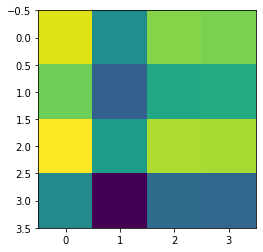

In [25]:
# 类表征的余弦相似性
res = sklearn.metrics.pairwise.cosine_similarity(class_embedding, class_embedding_compare)
plt.imshow(res)
plt.show()

In [26]:
# t-SNE分析,画图
def plot_scatter(emb, y_label, flag):
  t_sne_temp = TSNE(n_components=2).fit_transform(emb)
  y_label = [x + 10 * flag for x in y_label]
  plt.scatter(t_sne_temp[:,0], t_sne_temp[:,1], c=y_label)

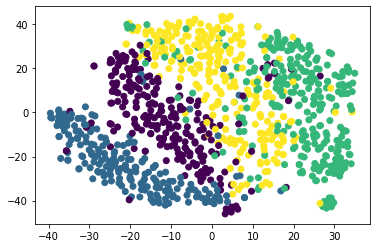

In [27]:
y_label = train_labels[10000:11000].numpy().tolist()
plot_scatter(seq_embs[10000:11000], y_label, 0)
plt.show()

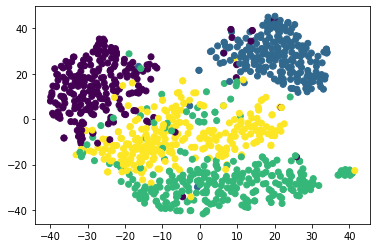

In [28]:
plot_scatter(seq_embs_compare[10000:11000], y_label, 1)
plt.show()

In [29]:
def plot_graphs(history1, history2, history3, metric, labels):
  plt.plot(history1.history[metric], label=labels[0])
  plt.plot(history2.history[metric], label=labels[1])
  plt.plot(history3.history[metric], label=labels[2])
  plt.xlabel("Batches")
  plt.ylabel(metric)
  plt.legend()
  plt.show()

Epoch 1/5
469/469 [==============================] - 281s 600ms/step - loss: 0.4942 - accuracy: 0.8228
Epoch 2/5
469/469 [==============================] - 281s 599ms/step - loss: 0.2670 - accuracy: 0.9117
Epoch 3/5
469/469 [==============================] - 281s 599ms/step - loss: 0.2042 - accuracy: 0.9322
Epoch 4/5
469/469 [==============================] - 281s 599ms/step - loss: 0.1638 - accuracy: 0.9452
Epoch 5/5
469/469 [==============================] - 281s 599ms/step - loss: 0.1345 - accuracy: 0.9550
Epoch 1/5
469/469 [==============================] - 280s 598ms/step - loss: 1.3841 - accuracy: 0.2835
Epoch 2/5
469/469 [==============================] - 280s 598ms/step - loss: 1.0834 - accuracy: 0.5229
Epoch 3/5
469/469 [==============================] - 281s 598ms/step - loss: 0.7750 - accuracy: 0.6887
Epoch 4/5
469/469 [==============================] - 281s 598ms/step - loss: 0.6015 - accuracy: 0.8016
Epoch 5/5
469/469 [==============================] - 280s 598ms/step - lo

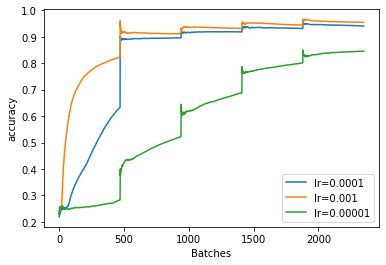

In [30]:
cnfg = BertConfig(hidden_size=hidden_size, num_labels=4, num_hidden_layers=6, num_attention_heads=4, intermediate_size=512)
model = TFBertForSequenceClassification(cnfg)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history1 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

cnfg = BertConfig(hidden_size=hidden_size, num_labels=4, num_hidden_layers=6, num_attention_heads=4, intermediate_size=512)
model = TFBertForSequenceClassification(cnfg)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history2 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

plot_graphs(history, history1, history2, 'accuracy', ['lr=0.0001','lr=0.001','lr=0.00001'])

Epoch 1/5
469/469 [==============================] - 191s 407ms/step - loss: 0.7165 - accuracy: 0.7052
Epoch 2/5
469/469 [==============================] - 191s 407ms/step - loss: 0.3178 - accuracy: 0.8957
Epoch 3/5
469/469 [==============================] - 191s 407ms/step - loss: 0.2491 - accuracy: 0.9178
Epoch 4/5
469/469 [==============================] - 191s 407ms/step - loss: 0.2069 - accuracy: 0.9319
Epoch 5/5
469/469 [==============================] - 191s 407ms/step - loss: 0.1799 - accuracy: 0.9409
Epoch 1/5
469/469 [==============================] - 370s 789ms/step - loss: 0.7199 - accuracy: 0.7032
Epoch 2/5
469/469 [==============================] - 370s 789ms/step - loss: 0.3296 - accuracy: 0.8918
Epoch 3/5
469/469 [==============================] - 370s 789ms/step - loss: 0.2593 - accuracy: 0.9146
Epoch 4/5
469/469 [==============================] - 370s 788ms/step - loss: 0.2189 - accuracy: 0.9280
Epoch 5/5
469/469 [==============================] - 370s 788ms/step - lo

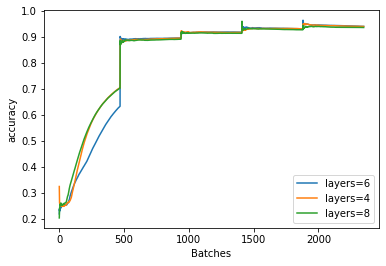

In [31]:
cnfg = BertConfig(hidden_size=hidden_size, num_labels=4, num_hidden_layers=4, num_attention_heads=4, intermediate_size=512)
model = TFBertForSequenceClassification(cnfg)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history1 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

cnfg = BertConfig(hidden_size=hidden_size, num_labels=4, num_hidden_layers=8, num_attention_heads=4, intermediate_size=512)
model = TFBertForSequenceClassification(cnfg)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history2 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

plot_graphs(history, history1, history2, 'accuracy', ['layers=6','layers=4','layers=8'])